In [1]:
import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.graphics.gofplots
import scipy.stats as stats
import torch
import torch.distributions as dist
import torch.nn as nn
from beanmachine.ppl.experimental.vi.variational_infer import (
    MeanFieldVariationalInference
)
from beanmachine.ppl.distribution import Flat

sns.set_style('darkgrid')

# Bayesian Robust Regression

In [5]:
n = 100
d = 10
df = 5.0

X_train = torch.randn(n, d)
beta_truth = torch.randn(d+1, 1)
y_train = torch.cat((X_train, torch.ones(n, 1)), -1).mm(beta_truth) \
    + dist.StudentT(df=4.0).sample((n, 1))


@bm.random_variable
def beta():
#     return dist.Independent(
#         dist.StudentT(df=4.0*torch.ones(d+1)),
#         1,
#     )
    return Flat(shape=(d+1))


@bm.random_variable
def X():
    return dist.Normal(0, 1)  # dummy


@bm.random_variable
def y():
    X_with_ones = torch.cat((X(), torch.ones(X().shape[0], 1)), -1)
    b = beta().squeeze()
    if b.dim() == 1:
        b = b.unsqueeze(0)
    mu = b.mm(X_with_ones.T).T
    return dist.Independent(
        dist.StudentT(df=df, loc=mu, scale=1),
        1,
    )


def annotate(data, **kws):
    coord = data['variable'].unique()
    assert len(coord) == 1
    ax = plt.gca()
    ax.axvline(x=beta_truth[coord[0]], color='r')

In [6]:
vi_dicts_normal = MeanFieldVariationalInference().infer(
    queries=[beta()],
    observations={
        X(): X_train,
        y(): y_train,
    },
    base_dist=dist.Normal,
    base_args={
        'loc': nn.Parameter(torch.tensor(0.0)),
        'scale': nn.Parameter(torch.tensor(1.0)),
    }
)
vi_dicts_student = MeanFieldVariationalInference().infer(
    queries=[beta()],
    observations={
        X(): X_train,
        y(): y_train,
    },
    base_dist=dist.StudentT,
    base_args={
        'df': nn.Parameter(torch.tensor(df)),
        'loc': nn.Parameter(torch.tensor(0.0)),
        'scale': nn.Parameter(torch.tensor(1.0)),
    }
)

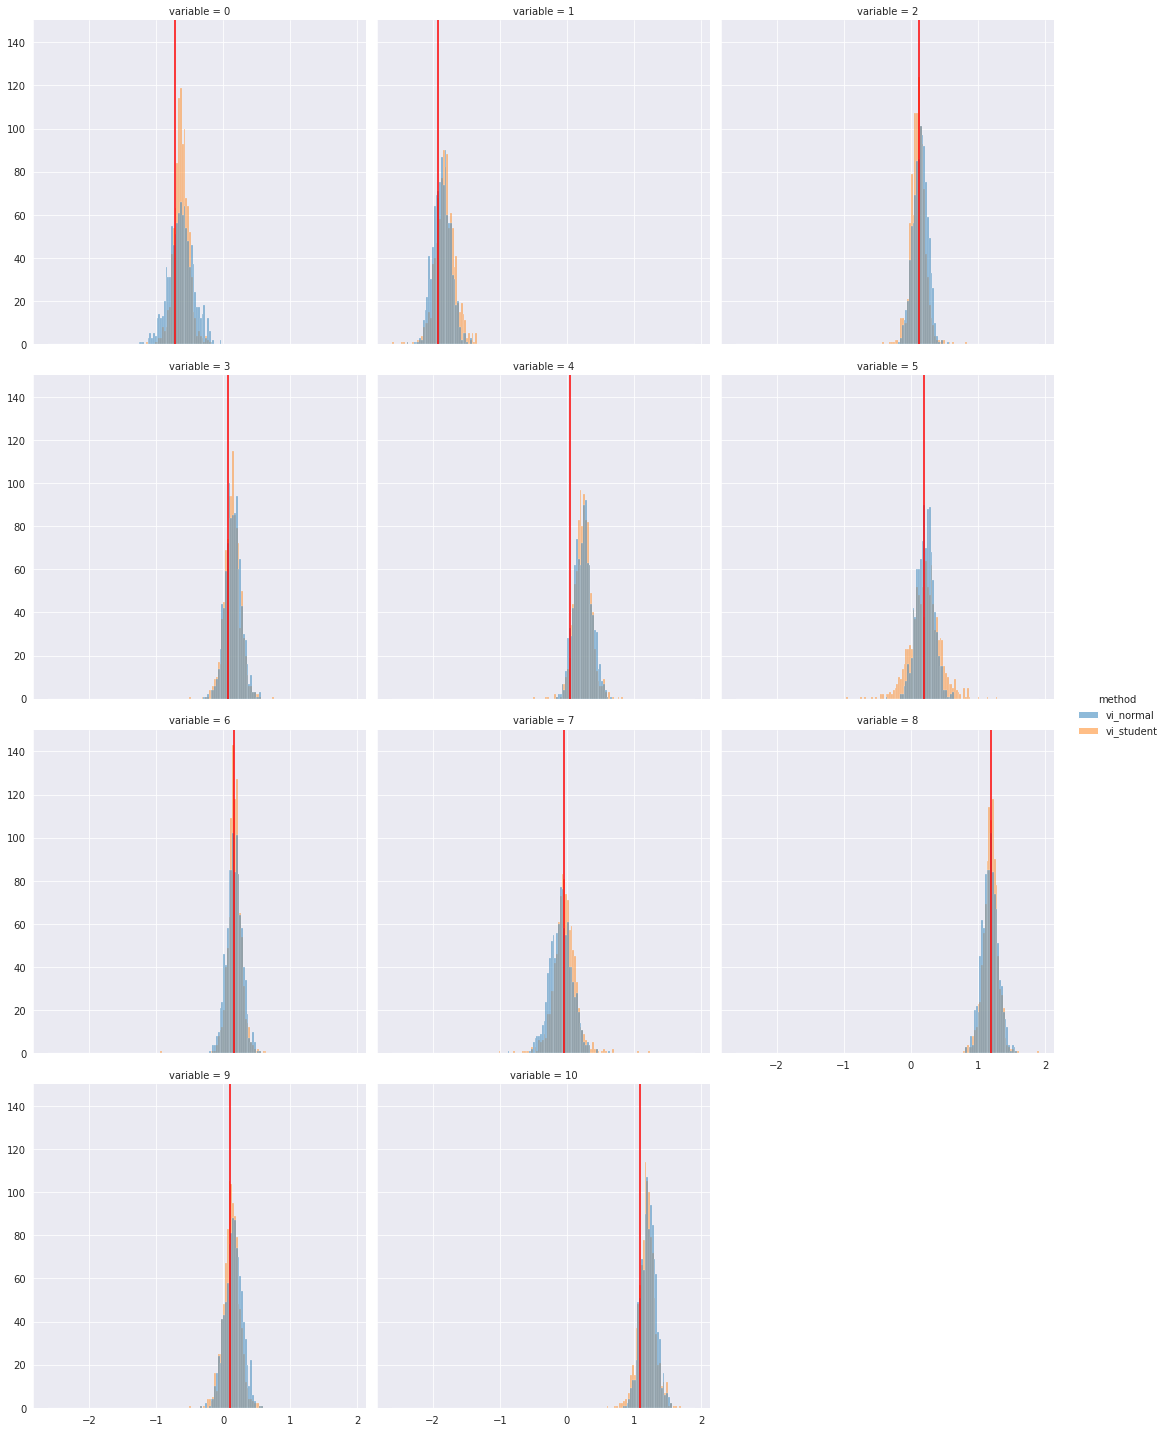

In [7]:
N = 1000
g = sns.displot(
    data=pd.concat((
        pd.DataFrame(vi_dicts_normal(beta()).sample((N,)).numpy()).assign(method='vi_normal'),
        pd.DataFrame(vi_dicts_student(beta()).sample((N,)).numpy()).assign(method='vi_student'),
    )).melt(id_vars='method'),
    x='value',
    col='variable',
    col_wrap=3,
    hue='method',
)
g.map_dataframe(annotate)

Log pointwise predictive density? [link](https://arxiv.org/pdf/1307.5928.pdf), underestimates $E_\pi \log p(\tilde{y} \mid \hat\theta)$ for a given point esitmate $\hat\theta(y)$

In [8]:
n_test = 1000
n_posterior = 100

X_test = torch.randn(n_test, d)
y_test = torch.cat((X_test, torch.ones(n_test, 1)), -1).mm(beta_truth) \
    + dist.StudentT(df=4.0).sample((n_test, 1))

for vi_dicts in [
    vi_dicts_normal,
    vi_dicts_student,
]:
    samples = vi_dicts(beta()).sample((n_posterior,))
    lppds = torch.stack([
        dist.StudentT(df=df).log_prob(y_test - torch.cat((X_test, torch.ones(n_test, 1)), -1).mm(b.unsqueeze(1))).sum() for b in torch.unbind(samples, dim=0)
    ], dim=0)
    print(lppds.mean())


tensor(-1799.3250)
tensor(-1806.3481)


QQ plots should show tail behavior

In [9]:
n_posterior = int(1e5)

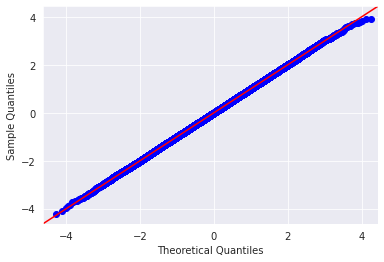

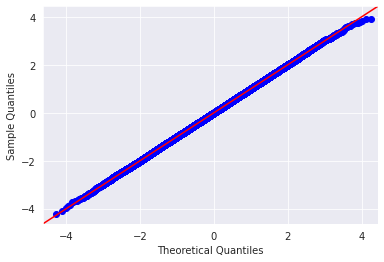

In [10]:
statsmodels.graphics.gofplots.qqplot(
    vi_dicts_normal(beta()).sample((n_posterior,))[:,6],
    fit=True,
    line="45",
    dist=stats.t,
    distargs=(df,)
)

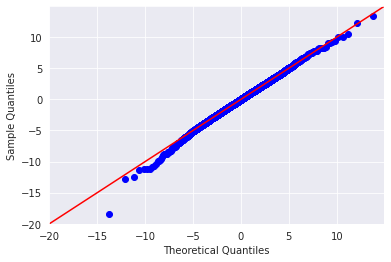

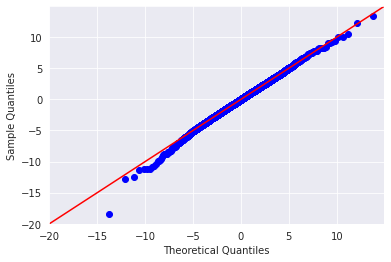

In [131]:
statsmodels.graphics.gofplots.qqplot(
    vi_dicts_student(beta()).sample((n_posterior,))[:,6],
    fit=True,
    line="45",
    dist=stats.t,
    distargs=(df,)
)

Random Walk MH does poorly here

In [11]:
samples = bm.SingleSiteRandomWalk().infer(
    queries=[beta()],
    observations={
        X(): X_train,
        y(): y_train,
    },
    num_samples=1000,
    num_chains=1,
)

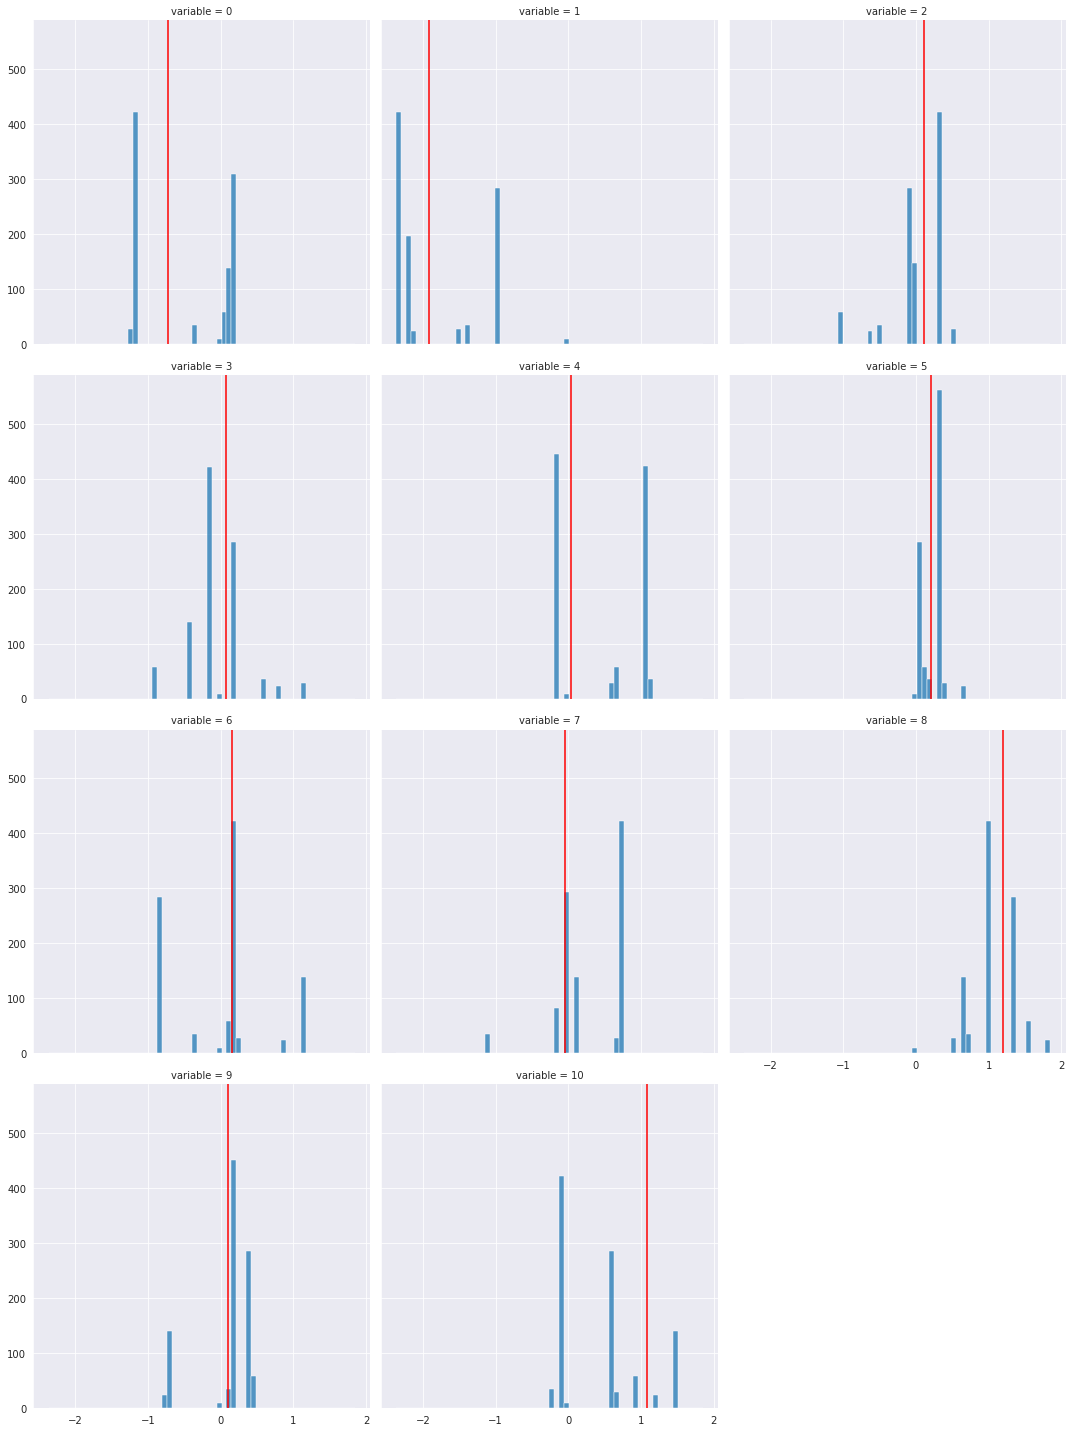

In [12]:
g = sns.displot(
    pd.DataFrame(samples[beta()].squeeze().numpy()).melt(),
    col='variable',
    col_wrap=3,
    x='value',
)
g.map_dataframe(annotate)